In [18]:
import numpy as np 
import pandas as pd 
import csv
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import random
import matplotlib.pyplot as plt
#import mylibs11 as l11


from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, Bidirectional
from keras.callbacks import ModelCheckpoint  




%matplotlib inline

In [19]:
np.random.seed(42)

# LOAD PREPARED DATASET

In [20]:
btc_data = pd.read_csv('BTC_DATA_fin.csv', index_col=0)
btc_data.index = pd.to_datetime(btc_data.index)

In [21]:
btc_data.columns

Index(['BTC_Open', 'BTC_High', 'BTC_Low', 'BTC_Close', 'BTC_Volume',
       'BTC_Market_Cap', 'Holiday', 'Weekend', 'wd_1', 'wd_2', 'wd_3', 'wd_4',
       'wd_5', 'wd_6', 'wd_7', 'season_1', 'season_2', 'season_3', 'season_4',
       'N_tran', 'Diff', 'Block_Size', 'Mi_rev', 'Cost_tran', 'MA7', 'SO',
       'Momentum_14', 'Momentum_7', 'Momentum_2'],
      dtype='object')

In [22]:
btc_data=btc_data[['BTC_Open', 'BTC_High', 'BTC_Low', 'BTC_Close', 'BTC_Volume',
       'BTC_Market_Cap','Holiday', 'MA7', 'SO',
       'Momentum_14', 'Momentum_7', 'Momentum_2']]

# TRAIN TEST SPLIT

In [23]:
#shift data
features = btc_data.shift(1).dropna() #.drop('BTC_Close', 1)
target = btc_data['BTC_Close'][1:]
prediction_days = 90

In [24]:
features_train = features[:len(features)-prediction_days]
features_test = features[len(features)-prediction_days:]

target_train = target[:len(features)-prediction_days]
target_test = target[len(features)-prediction_days:]

# NORMALIZATION

In [8]:
X_min_max_scaler = MinMaxScaler()
y_min_max_scaler = MinMaxScaler()
features_train_scaled = pd.DataFrame(X_min_max_scaler.fit_transform(features_train), 
                                     columns=features_train.columns, index=features_train.index)
features_test_scaled = pd.DataFrame(X_min_max_scaler.transform(features_test),
                                    columns=features_test.columns,index=features_test.index)
target_train_scaled = y_min_max_scaler.fit_transform(target_train.values.reshape(-1, 1))
target_test_scaled = y_min_max_scaler.transform(target_test.values.reshape(-1, 1))

# Univariate LSTM Models

## Vanilla LSTM

In [237]:
X = features_train_scaled.values
X_test = features_test_scaled.values

In [238]:
#rescale to 1d
y = target_train_scaled.ravel()
y_test = target_test_scaled.ravel()

In [239]:
n_features = 1 #unvariate so we predict 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [240]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [241]:
X.shape

(1946, 12, 1)

In [242]:
# define model 
model = Sequential() 
model.add(LSTM(64, activation='relu', input_shape=(X.shape[1], n_features))) 
model.add(Dense(1)) 
#model.add(Activation('linear'))
model.compile(optimizer='adam', loss='mse')


In [243]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 64)                16896     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [244]:
# fit 
checkpointer = ModelCheckpoint(filepath='saved_models/LSTM_vanilla_less.hdf5', 
                               verbose=1, monitor='val_loss', save_best_only=True)
history = model.fit(X, y, epochs=50, validation_split=0.1, verbose=1)

Train on 1751 samples, validate on 195 samples
Epoch 1/50
1751/1751 [==============================] - 2s 1ms/step - loss: 0.0141 - val_loss: 0.0032
Epoch 2/50
1751/1751 [==============================] - 1s 469us/step - loss: 0.0018 - val_loss: 0.0029
Epoch 3/50
1751/1751 [==============================] - 1s 475us/step - loss: 9.4594e-04 - val_loss: 9.3596e-04
Epoch 4/50
1751/1751 [==============================] - 1s 451us/step - loss: 5.7671e-04 - val_loss: 0.0014
Epoch 5/50
1751/1751 [==============================] - 1s 458us/step - loss: 4.7933e-04 - val_loss: 7.8861e-04
Epoch 6/50
1751/1751 [==============================] - 1s 473us/step - loss: 5.8153e-04 - val_loss: 6.6151e-04
Epoch 7/50
1751/1751 [==============================] - 1s 462us/step - loss: 4.2913e-04 - val_loss: 8.0515e-04
Epoch 8/50
1751/1751 [==============================] - 1s 478us/step - loss: 4.0980e-04 - val_loss: 6.2744e-04
Epoch 9/50
1751/1751 [==============================] - 1s 471us/step - loss: 4

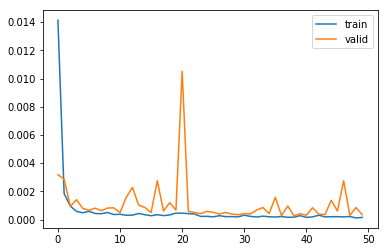

In [245]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

In [246]:
preds = model.predict(X_test)

In [247]:
preds= y_min_max_scaler.inverse_transform(preds.reshape(1, -1))
y_test=y_min_max_scaler.inverse_transform(y_test.reshape(1, -1))

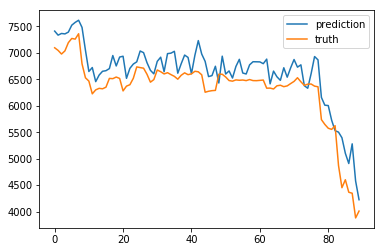

In [248]:
plt.plot(preds.ravel(), label='prediction')
plt.plot(y_test.ravel(), label='truth')
plt.legend()
plt.show()

In [249]:
np.sqrt(mean_squared_error(y_test,preds))

364.64229470768601

## STACKED LSTM

In [261]:
X = features_train_scaled.values
X_test = features_test_scaled.values

In [262]:
y = target_train_scaled.ravel()
y_test = target_test_scaled.ravel()

In [263]:
n_features = 1 #unvariate so we predict 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [264]:
model = Sequential()


model.add(LSTM(64, input_shape=(X.shape[1], n_features),return_sequences=True))
model.add(Dropout(0.2)) #0.2
model.add(LSTM(128,return_sequences=False)) #, dropout_W=0.2))
model.add(Dropout(0.3)) #0.2
model.add(Dense(units=1))
#model.add(Activation('linear')) #'linear'

In [265]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [266]:
checkpointer = ModelCheckpoint(filepath='saved_models/LSTM_stacked_less.hdf5', 
                               verbose=1, save_best_only=True)
epochs = 50 #100
batch_size=10
history = model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=1, callbacks=[checkpointer]) #valid=0.2#,shuffle=True

Train on 1751 samples, validate on 195 samples
Epoch 1/50
1751/1751 [==============================] - 9s 5ms/step - loss: 0.0046 - val_loss: 0.0134
Epoch 2/50
1751/1751 [==============================] - 6s 4ms/step - loss: 0.0023 - val_loss: 0.0070
Epoch 3/50
1751/1751 [==============================] - 7s 4ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 4/50
1751/1751 [==============================] - 7s 4ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 5/50
1751/1751 [==============================] - 7s 4ms/step - loss: 9.4893e-04 - val_loss: 0.0048
Epoch 6/50
1751/1751 [==============================] - 7s 4ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 7/50
1751/1751 [==============================] - 7s 4ms/step - loss: 0.0012 - val_loss: 8.8331e-04
Epoch 8/50
1751/1751 [==============================] - 7s 4ms/step - loss: 7.6821e-04 - val_loss: 0.0013
Epoch 9/50
1751/1751 [==============================] - 7s 4ms/step - loss: 6.2210e-04 - val_loss: 5.1510e-04
Epoch 10/50
175

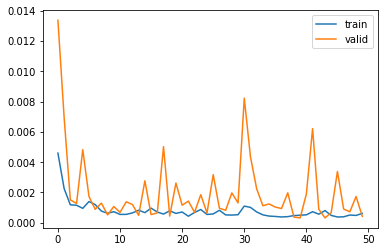

In [267]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

In [268]:
model.load_weights('saved_models/LSTM_stacked_less.hdf5')

In [269]:
preds = model.predict(X_test)

In [270]:
preds= y_min_max_scaler.inverse_transform(preds.reshape(1, -1))
y_test=y_min_max_scaler.inverse_transform(y_test.reshape(1, -1))

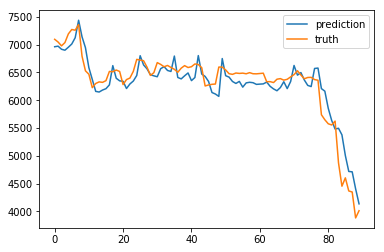

In [271]:
plt.plot(preds.ravel(), label='prediction')
plt.plot(y_test.ravel(), label='truth')
plt.legend()
plt.show()

In [272]:
np.sqrt(mean_squared_error(y_test,preds))

232.70887553649982

## Bidirectional LSTM

In [278]:
X = features_train_scaled.values
X_test = features_test_scaled.values

In [279]:
y = target_train_scaled.ravel()
y_test = target_test_scaled.ravel()

In [280]:
n_features = 1 #unvariate so we predict 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [285]:
# define model 
model = Sequential() 
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(X.shape[1], n_features))) 
model.add(Dense(1)) 
model.compile(optimizer='adam', loss='mse')

In [286]:
checkpointer = ModelCheckpoint(filepath='saved_models/LSTM_bdir_less.hdf5', 
                               verbose=2, save_best_only=True)
epochs = 50 #100
batch_size=10
history = model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=0, callbacks=[checkpointer]) #valid=0.2#,shuffle=True

Epoch 00001: val_loss improved from inf to 0.00128, saving model to saved_models/LSTM_bdir_less.hdf5
Epoch 00002: val_loss improved from 0.00128 to 0.00051, saving model to saved_models/LSTM_bdir_less.hdf5
Epoch 00003: val_loss improved from 0.00051 to 0.00043, saving model to saved_models/LSTM_bdir_less.hdf5
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss improved from 0.00043 to 0.00038, saving model to saved_models/LSTM_bdir_less.hdf5
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss did not improve
Epoch 00013: val_loss did not improve
Epoch 00014: val_loss did not improve
Epoch 00015: val_loss improved from 0.00038 to 0.00025, saving model to saved_models/LSTM_bdir_less.hdf5
Epoch 00016: val_loss did not improve
Epoch 00017: val_loss did not improve
Epoch 00018: val_loss d

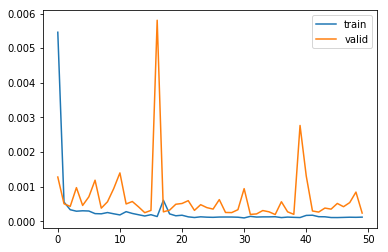

In [287]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

In [288]:
model.load_weights('saved_models/LSTM_bdir_less.hdf5')

In [289]:
preds = model.predict(X_test)

In [290]:
preds= y_min_max_scaler.inverse_transform(preds.reshape(1, -1))
y_test=y_min_max_scaler.inverse_transform(y_test.reshape(1, -1))

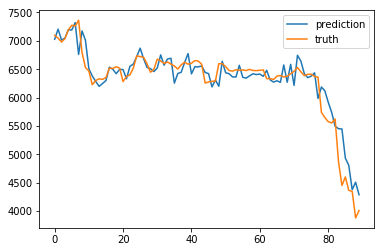

In [291]:
plt.plot(preds.ravel(), label='prediction')
plt.plot(y_test.ravel(), label='truth')
plt.legend()
plt.show()

In [292]:
np.sqrt(mean_squared_error(y_test,preds))

227.86163426164606

# Multivariate LSTM Models

## Multiple Input Series 

## Vanilla LSTM

In [9]:
def window_data(df, window_len):
    window_data = []
    for i in range(len(df) - window_len):
        tmp = df[i: (i + window_len)].copy()
        window_data.append(tmp.values)
    return np.array(window_data)

In [10]:
window_len=7
X_train = window_data(features_train_scaled, window_len=window_len)
X_test = window_data(features_test_scaled, window_len=window_len)
    

y_train = target_train_scaled[window_len:]
y_test = target_test_scaled[window_len:]

In [372]:
model = Sequential()

model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(units=1))
#model.add(Activation('linear')) #'relu'

In [373]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [374]:
checkpointer = ModelCheckpoint(filepath='saved_models/LSTM2_multi7_less', 
                               verbose=0, save_best_only=True)
epochs = 30 #100
batch_size=5
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=0, callbacks=[checkpointer]) #valid=0.2#,shuffle=True

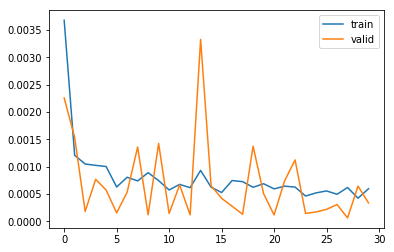

In [375]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

In [376]:
preds = model.predict(X_test)

In [377]:
preds= y_scaler.inverse_transform(preds)

In [378]:
y_test=y_scaler.inverse_transform(y_test)

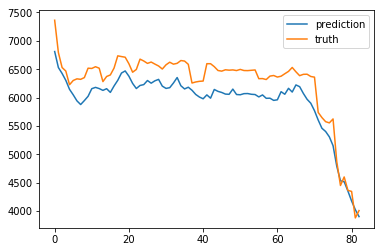

In [379]:
plt.plot(preds, label='prediction')
plt.plot(y_test, label='truth')
plt.legend()
plt.show()

In [380]:
np.sqrt(mean_squared_error(y_test,preds))

347.21411044428226

# Multiple Stacked LSTM

In [510]:
X_min_max_scaler = MinMaxScaler()
y_min_max_scaler = MinMaxScaler()
features_train_scaled = pd.DataFrame(X_min_max_scaler.fit_transform(features_train), 
                                     columns=features_train.columns, index=features_train.index)
features_test_scaled = pd.DataFrame(X_min_max_scaler.transform(features_test),
                                    columns=features_test.columns,index=features_test.index)
target_train_scaled = y_min_max_scaler.fit_transform(target_train.values.reshape(-1, 1))
target_test_scaled = y_min_max_scaler.transform(target_test.values.reshape(-1, 1))

In [511]:
window_len=7
X_train = window_data(features_train_scaled, window_len=window_len)
X_test = window_data(features_test_scaled, window_len=window_len)
    

y_train = target_train_scaled[window_len:]
y_test = target_test_scaled[window_len:]

In [512]:
model = Sequential()

model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model.add(Dropout(0.3)) #0.2
model.add(LSTM(128,return_sequences=False)) #, dropout_W=0.2))
model.add(Dropout(0.5)) #0.2
model.add(Dense(units=1))
model.add(Activation('linear')) #'linear'

In [513]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [514]:
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/LSTM_stacked7_less.hdf5', 
                               verbose=0, save_best_only=True)
epochs = 30 #100
batch_size=10
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=0, callbacks=[checkpointer]) #valid=0.2#,shuffle=True

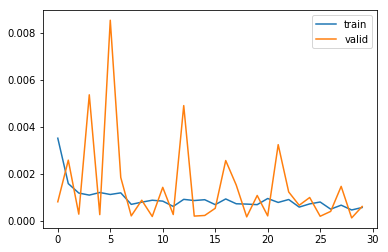

In [515]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

In [516]:
preds = model.predict(X_test)

In [517]:
preds= y_scaler.inverse_transform(preds)

In [518]:
y_test=y_scaler.inverse_transform(y_test)

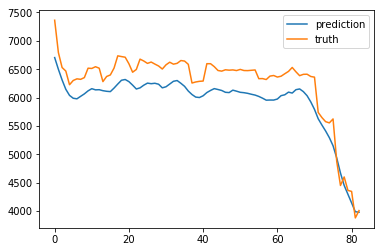

In [519]:
plt.plot(preds, label='prediction')
plt.plot(y_test, label='truth')
plt.legend()
plt.show()

In [520]:
np.sqrt(mean_squared_error(y_test,preds))

352.57500300058791

# Different windows sizes

In [541]:
X_min_max_scaler = MinMaxScaler()
y_min_max_scaler = MinMaxScaler()
features_train_scaled = pd.DataFrame(X_min_max_scaler.fit_transform(features_train), 
                                     columns=features_train.columns, index=features_train.index)
features_test_scaled = pd.DataFrame(X_min_max_scaler.transform(features_test),
                                    columns=features_test.columns,index=features_test.index)
target_train_scaled = y_min_max_scaler.fit_transform(target_train.values.reshape(-1, 1))
target_test_scaled = y_min_max_scaler.transform(target_test.values.reshape(-1, 1))

In [542]:
#change window size
window_len=60
X_train = window_data(features_train_scaled, window_len=window_len)
X_test = window_data(features_test_scaled, window_len=window_len)
    
y_train = target_train_scaled[window_len:]
y_test = target_test_scaled[window_len:]

In [543]:
model = Sequential()

model.add(LSTM(30, input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model.add(Dropout(0.3)) #0.2
model.add(LSTM(60,return_sequences=False)) #, dropout_W=0.2))
model.add(Dropout(0.5)) #0.2
model.add(Dense(units=1))
model.add(Activation('linear')) #'linear'

In [544]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [545]:
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/LSTM_stacked60_less.hdf5', 
                               verbose=0, save_best_only=True)
epochs = 50 #100
batch_size=10
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=0, callbacks=[checkpointer]) #valid=0.2#,shuffle=True

# WINDOWS SIZE = 1

In [222]:
model_name = 'saved_models/LSTM_stacked1_less.hdf5'
model.load_weights(model_name)

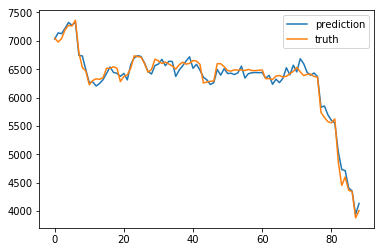

In [464]:
preds = model.predict(X_test)
preds= y_scaler.inverse_transform(preds)
y_test=y_scaler.inverse_transform(y_test)
plt.plot(preds, label='prediction')
plt.plot(y_test, label='truth')
plt.legend()
plt.show()

In [465]:
np.sqrt(mean_squared_error(y_test,preds))

93.6451974714508

# WINDOWS SIZE = 3

In [212]:
model_name = 'saved_models/LSTM_stacked3_less.hdf5'
model.load_weights(model_name)

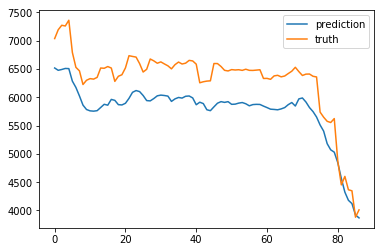

In [457]:
preds = model.predict(X_test)
preds= y_scaler.inverse_transform(preds)
y_test=y_scaler.inverse_transform(y_test)
plt.plot(preds, label='prediction')
plt.plot(y_test, label='truth')
plt.legend()
plt.show()

In [458]:
np.sqrt(mean_squared_error(y_test,preds))

558.30333781726677

# WINDOWS SIZE = 5

In [472]:
model_name = 'saved_models/LSTM_stacked5_less.hdf5'
model.load_weights(model_name)

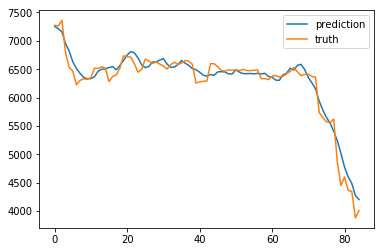

In [473]:
preds = model.predict(X_test)
preds= y_scaler.inverse_transform(preds)
y_test=y_scaler.inverse_transform(y_test)
plt.plot(preds, label='prediction')
plt.plot(y_test, label='truth')
plt.legend()
plt.show()

In [474]:
np.sqrt(mean_squared_error(y_test,preds))

148.11232918521489

# WINDOWS SIZE = 7

In [ ]:
model_name = 'saved_models/LSTM_stacked7_less.hdf5'
model.load_weights(model_name)

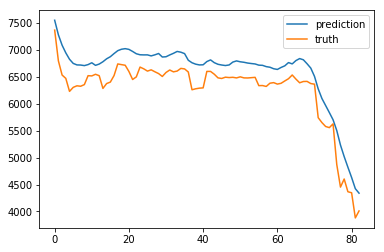

In [480]:
preds = model.predict(X_test)
preds= y_scaler.inverse_transform(preds)
y_test=y_scaler.inverse_transform(y_test)
plt.plot(preds, label='prediction')
plt.plot(y_test, label='truth')
plt.legend()
plt.show()

In [481]:
np.sqrt(mean_squared_error(y_test,preds))

361.90493572268878

# WINDOWS SIZE = 10

In [182]:
model_name = 'saved_models/LSTM_stacked10_less.hdf5'

In [183]:
model.load_weights(model_name)

In [486]:
preds = model.predict(X_test)
preds= y_scaler.inverse_transform(preds)
y_test=y_scaler.inverse_transform(y_test)

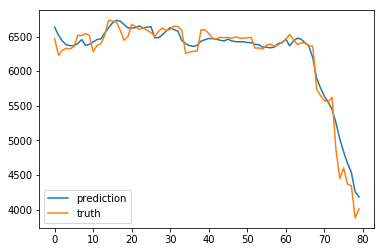

In [487]:
plt.plot(preds, label='prediction')
plt.plot(y_test, label='truth')
plt.legend()
plt.show()

In [488]:
np.sqrt(mean_squared_error(y_test,preds))

136.37545424117661

'saved_models/LSTM_stacked7_128256.hdf5' error 203

# WINDOWS SIZE = 14

In [192]:
model_name = 'saved_models/LSTM_stacked14_less.hdf5'
model.load_weights(model_name)

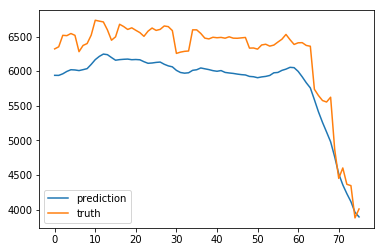

In [532]:
preds = model.predict(X_test)
preds= y_scaler.inverse_transform(preds)
y_test=y_scaler.inverse_transform(y_test)
plt.plot(preds, label='prediction')
plt.plot(y_test, label='truth')
plt.legend()
plt.show()

In [533]:
np.sqrt(mean_squared_error(y_test,preds))

434.64441539584476

# WINDOWS SIZE = 30

In [232]:
model_name = 'saved_models/LSTM_stacked30_less.hdf5'
model.load_weights(model_name)

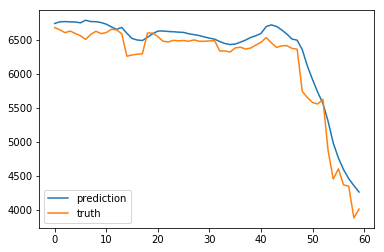

In [539]:
preds = model.predict(X_test)
preds= y_scaler.inverse_transform(preds)
y_test=y_scaler.inverse_transform(y_test)
plt.plot(preds, label='prediction')
plt.plot(y_test, label='truth')
plt.legend()
plt.show()

In [540]:
np.sqrt(mean_squared_error(y_test,preds))

212.70951032221262

# WINDOWS SIZE = 60

In [242]:
model_name = 'saved_models/LSTM_stacked60_less.hdf5'
model.load_weights(model_name)

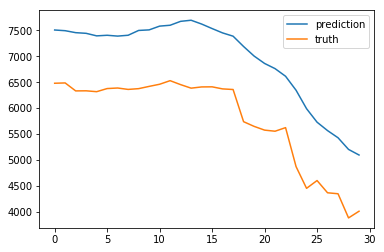

In [546]:
preds = model.predict(X_test)#.squeeze()
preds= y_scaler.inverse_transform(preds)
y_test=y_scaler.inverse_transform(y_test)
plt.plot(preds, label='prediction')
plt.plot(y_test, label='truth')
plt.legend()
plt.show()

In [547]:
np.sqrt(mean_squared_error(y_test,preds))

1173.4234120092378

# BEST MODEL

In [25]:
X_min_max_scaler = MinMaxScaler()
y_min_max_scaler = MinMaxScaler()
features_train_scaled = pd.DataFrame(X_min_max_scaler.fit_transform(features_train), 
                                     columns=features_train.columns, index=features_train.index)
features_test_scaled = pd.DataFrame(X_min_max_scaler.transform(features_test),
                                    columns=features_test.columns,index=features_test.index)
target_train_scaled = y_min_max_scaler.fit_transform(target_train.values.reshape(-1, 1))
target_test_scaled = y_min_max_scaler.transform(target_test.values.reshape(-1, 1))

In [26]:
#change window size
window_len=1
X_train = window_data(features_train_scaled, window_len=window_len)
X_test = window_data(features_test_scaled, window_len=window_len)
    
y_train = target_train_scaled[window_len:]
y_test = target_test_scaled[window_len:]

In [27]:
model = Sequential()

model.add(LSTM(30, input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model.add(Dropout(0.3)) #0.2
model.add(LSTM(60,return_sequences=False)) #, dropout_W=0.2))
model.add(Dropout(0.5)) #0.2
model.add(Dense(units=1))
model.add(Activation('linear')) #'linear'

In [28]:
model.compile(loss='mean_squared_error', optimizer='adam')

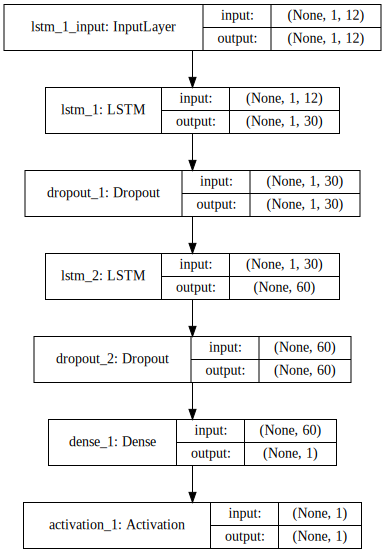

In [30]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [32]:
model_name = 'saved_models/LSTM_stacked1_less.hdf5'
model.load_weights(model_name)

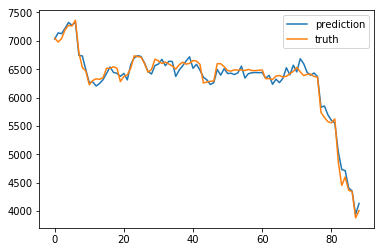

In [34]:
preds = model.predict(X_test)
preds= y_min_max_scaler.inverse_transform(preds)
y_test=y_min_max_scaler.inverse_transform(y_test)
plt.plot(preds, label='prediction')
plt.plot(y_test, label='truth')
plt.legend()
plt.show()

In [35]:
np.sqrt(mean_squared_error(y_test,preds))

93.6451974714508

In [36]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

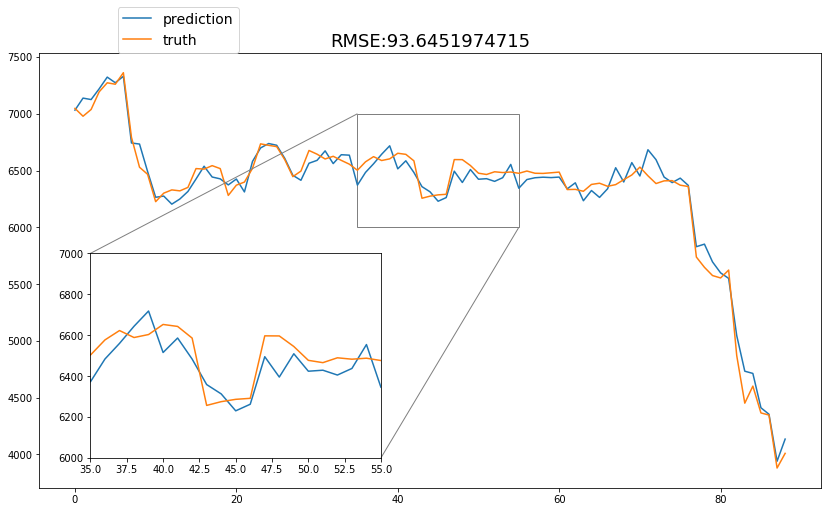

In [37]:
fig, ax1 = plt.subplots(1,figsize=(14, 8))

ax1.plot(preds, label='prediction')
ax1.plot(y_test, label='truth')
ax1.set_title('RMSE:'+str(np.sqrt(mean_squared_error(y_test,preds))), fontsize=18)
ax1.legend(bbox_to_anchor=(0.1, 1), loc="best",borderaxespad=0., prop={'size': 14})
# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset

axins = zoomed_inset_axes(ax1, 1.8, loc=3, bbox_to_anchor=(172, 97)) # zoom-factor: 2

axins.plot(preds.ravel())
axins.plot(y_test.ravel())
axins.set_xlim([35, 55])
axins.set_ylim([6000, 7000])


mark_inset(ax1, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.show()